# Using SHARPy's UVLM to find the lift and drag curve of an aircraft

In this advanced tutorial, we will use SHARPy's UVLM (linear and nonlinear) to find the lift curve slope of an aircraft, and see the effect linearisation has on it.

The problem will be set up as follows:
 
* The aircraft is placed in a steady uniform velocity aligned with the inertial `x` direction.
* The angle of attack of the aircraft will be applied by rotating the aircraft by said angle (changing the `orientation` of the beam in `BeamLoader`)
* The static solution will be computed using `StaticUvlm`
* The forces at this condition will be the output using `AeroForcesCalculator`
* The `LinearAssembler` will be used to linearise the system. Note, we would like the UVLM to be projected onto the structural degrees of freedom thus we need to produce a `LinearAeroelastic` system, from which we will use the linearised UVLM only.
* We will perturb the linearised UVLM to approximate the lift and drag curves in the vicinity of the linearisation angle of attack

## Definitions

The inertial frame G is set up to be with `z` pointing upwards.

The aircraft `A` frame is coincident with the `G` frame when the aircraft is not rotated. `x` is downstream and `y` points towards the right wing.

The stability axis `S` has `x` aligned with the flow, `y` is the same as the aircraft's `y` and `z` completes the set.

Lift and drag are defined as the aerodynamic forces projected onto the stability `z` and `x` axes, respectively. The angle between `x_s` and `x_a` is the angle of attack `alpha`.

## Output forces and frame of reference...

The output forces are defined in the `A` frame, thus they need to be projected onto the `S` frame to get the lift and drag. If using `AeroForcesCalculator` this will be done for you, as `S` will be coincident with `G` if we simply rotate the structure. However, once we perturb the UVLM the stability axes will change.

The lift and drag are defined as 

$$ F^S(\alpha) = C^{SA}(\alpha)F^A $$

where $C^{SA}(\alpha)$ projects a vector in `A` to `S`.

Therefore, perturbations to the lift and drag will result in 

$$\delta F^S = \frac{\partial}{\partial\alpha}\left(C^{SA}F_0^A\right)\delta\alpha + C_0^{SA}\delta F^A $$

The term $\delta F^A$ is actually the output from the UVLM (when expressed in the structural degrees of freedom) and can therefore be computed simply as $\delta F^A = H(0) \delta v^A$, where $H(0)$ is the steady-state transfer function of the UVLM and $\delta v^A$ is the perturbation input in the `A` frame of reference.

These inputs and frames of reference are shown in the figure below

## Notes:

This Jupyter notebook requires of the test script `inputsimulation/test_linear_inputs.py`. If you would like to execute this script yourself you may need to comment out the `tearDown` method, since that deletes all the case files required for this notebook.


In [1]:
import numpy as np

import scipy.stats as stats
import scipy.signal as scsig
import scipy.io as scio
import h5py
import sharpy.utils.h5utils as h5utils
import sharpy.utils.algebra as algebra
import sharpy
import os

try:
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    no_plots = False
except ModuleNotFoundError:
    no_plots = True
else:
    mpl.rcParams['figure.dpi'] = 100
    mpl.rcParams['figure.figsize'] = (8, 6)
    %config InlineBackend.figure_format = 'retina'

In [2]:
S_ref = 32
u_inf = 10
rho = 1.225
qS = 0.5 * rho * u_inf ** 2 * S_ref

In [3]:
sharpy_path = os.path.dirname(sharpy.__file__)


In [4]:
uvlm = np.loadtxt(sharpy_path + '/../tests/linear/inputsimulation/nonlinear_results.txt', skiprows=1, delimiter=',')
uvlm[:, 1:] /= qS

#curve fitting lift and drag 
lift_poly = np.polyfit(uvlm[:, 0] * np.pi/180, uvlm[:, -1], deg=1)

drag_poly = np.polyfit(uvlm[:, 0] * np.pi/180, uvlm[:, 1], deg=2)


The initial velocity is defined in the inertial frame as $V_0^G = U_\infty[-1, 0, 0]$. The new desired velocity is, for simplicity also expressed in the inertial frame as $V' = U_\infty[-\cos(\delta\alpha), 0, -\sin(\delta\alpha)]$, thus leading to the perturbation velocity $\delta V^G = V' - V_0$. The input to the UVLM will then be $\delta v^A = C^{AG}\delta V^G$.

For this tutorial we will use two scripts:
* One generates a `StaticUvlm` solution and saves the forces using `AeroForcesCalculator` at various angle of attack
* One generates a linearised UVLM system projected onto the structural degrees of freedom at three angles of attack

In [5]:
def process_linear(path_to_case, case_name, alpha0, alpha_min, alpha_max, n_evals, return_freq='D'):
    # load the aeroelastic system
    aoasys = scio.loadmat('{:s}/{:s}/savedata/{:s}.linss.mat'.format(path_to_case, case_name, case_name))
    # load the linearised uvlm
    uvlmsys = scio.loadmat('{:s}/{:s}/savedata/{:s}.uvlmss.mat'.format(path_to_case, case_name, case_name))
    
    
    # we need to compute the steady state transfer function of the discrete time uvlm
    H0 = uvlmsys['C'].dot(np.linalg.inv(np.eye(uvlmsys['A'].shape[0]) - uvlmsys['A']).dot(uvlmsys['B'])) + uvlmsys['D']
    
    cga = algebra.quat2rotation(algebra.euler2quat(np.array([0, alpha0, 0])))

    vx_ind = 20 # x_a input index
    vz_ind = 22 # z_a input index
    
    forces = np.zeros((n_evals, 4))
    for i_alpha, dalpha in enumerate(np.linspace(alpha_min, alpha_max, n_evals)-alpha0):
        alpha = alpha0 + dalpha  # rad
        deuler = np.array([0, dalpha, 0])
        euler0 = np.array([0, alpha0, 0])

        u = np.zeros((uvlmsys['B'].shape[1]))  # input vector
        V0 = np.array([-1, 0, 0], dtype=float) * u_inf  #G
        Vp = u_inf * np.array([-np.cos(dalpha), 0 , -np.sin(dalpha)])  #G
    
        dvg = Vp - V0  # G
        dva = cga.T.dot(dvg)  # A
        dvz = dva[2]
        dvx = dva[0]
        
        # Need to scale the mode shapes by the rigid body mode factor
        u[vx_ind] = dvx / aoasys['mode_shapes'][-9,0]
        u[vz_ind] = dvz / aoasys['mode_shapes'][-7,2]
        
        # and the same with the output forces
        flin = H0.dot(u)[:3].real / aoasys['mode_shapes'][-9,0]  # A
        F0A = aoasys['forces_aero_beam_dof'][0, :3] / aoasys['mode_shapes'][-9,0]  # A - forces at the linearisation
        LD0 = cga.dot(F0A)  # Lift and drag at the linearisation point
    
        forces[i_alpha, 0] = (alpha0 + dalpha) * 180 / np.pi # deg
        LD = LD0 + algebra.der_Ceuler_by_v(euler0, F0A).dot(deuler) + cga.dot(flin)  # stability axes
        forces[i_alpha, 1:] = LD / qS
    
    if return_freq=='freq':
        return H0
    elif return_freq=='D':
        return uvlmsys['D']
    elif return_freq=='B':
        return uvlmsys['B']
    else:
        return forces

In [6]:
linear_systems = []
path_to_systems = sharpy_path + '/../tests/linear/inputsimulation/src/output/'

for alpha in [2, 4]:
    case = {}
    case['alpha0'] = alpha
    case['case_name'] = 'simple_HALE_uvlm_alpha{:04g}_rom1_nmodes20'.format(case['alpha0']*100)
    case['path'] = path_to_systems + '/' + case['case_name']
    linear_systems.append(case)

In [7]:
for case in linear_systems:
    case['data'] = process_linear(case['path'], case['case_name'], alpha0=case['alpha0']*np.pi/180, alpha_min=0, alpha_max=5*np.pi/180, n_evals=11, return_freq='forces')

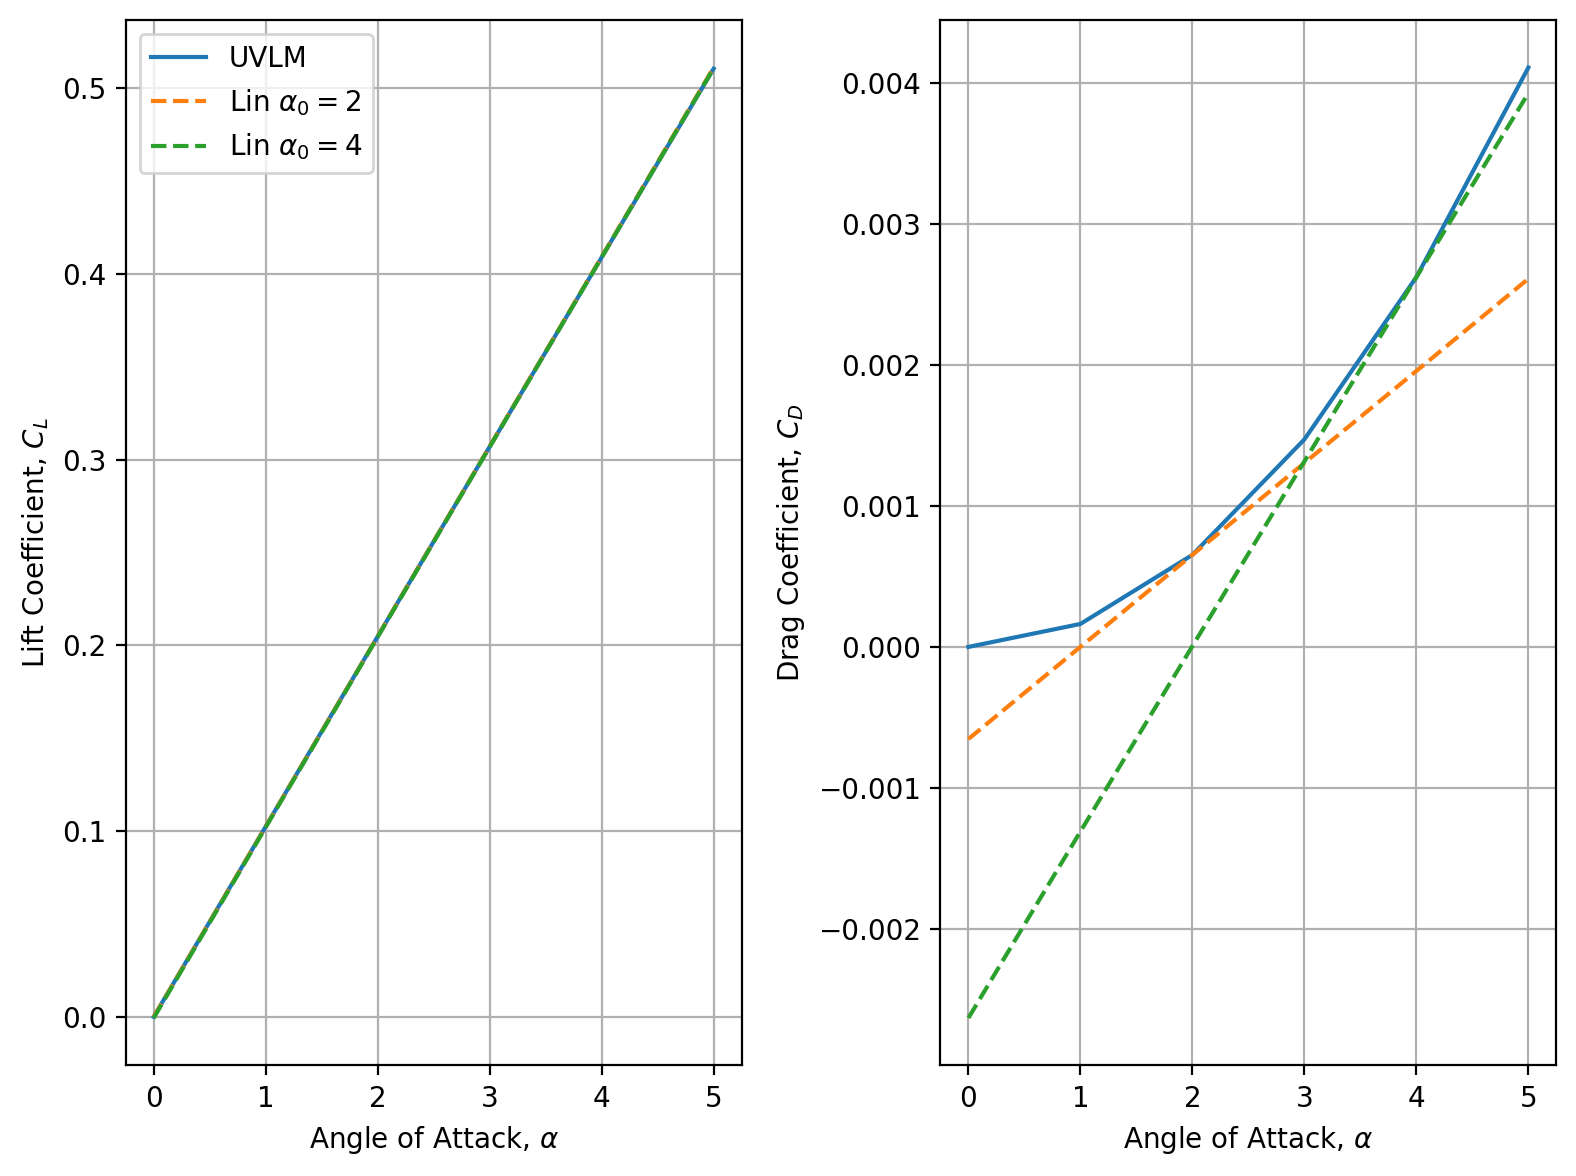

In [8]:
if not no_plots:
    fig, ax = plt.subplots(ncols=2)

    ax[0].plot(uvlm[:, 0], uvlm[:, -1], label='UVLM')
    ax[1].plot(uvlm[:, 0], uvlm[:, 1])


    for case in linear_systems:
        ax[0].plot(case['data'][:, 0], case['data'][:, -1], ls='--', label=r'Lin $\alpha_0={:g}$'.format(case['alpha0']))
        ax[1].plot(case['data'][:, 0], case['data'][:, 1], ls='--')

    ax[0].set_ylabel('Lift Coefficient, $C_L$')
    ax[1].set_ylabel('Drag Coefficient, $C_D$')

    ax[0].set_xlabel(r'Angle of Attack, $\alpha$')
    ax[1].set_xlabel(r'Angle of Attack, $\alpha$')


    plt.tight_layout()
    ax[0].grid()
    ax[1].grid()
    ax[0].legend();

In [9]:
for case in linear_systems:
    print('Alpha0 = {:.1f} deg'.format(case['alpha0']))
    cla = (case['data'][-1, -1] - case['data'][0, -1]) / (case['data'][-1, 0] - case['data'][0, 0]) * 180/np.pi
    print('CL_alpha = {:3f} / rad'.format(cla))
    nl_cla = lift_poly[0]
    print('Nonlinear: CL_alpha = {:4f}'.format(nl_cla))
    print('Diff {:.2e}'.format(np.abs(nl_cla - cla) / nl_cla))
    np.testing.assert_allclose(cla, nl_cla, rtol=1e-6, atol=1e-2 * nl_cla)



    cda = (case['data'][-1, 1] - case['data'][0, 1]) / (case['data'][-1, 0] - case['data'][0, 0]) * 180/np.pi
    print('CD_alpha @ alpha0 = {:4f} / rad'.format(cda))

    nl_cda = 2 * drag_poly[0] * case['alpha0'] * np.pi/180 + drag_poly[1]
    print('Nonlinear: CD_alpha = {:4f}'.format(nl_cda))
    print('Diff {:.2e}'.format(np.abs(nl_cda - cda) / nl_cda))
    np.testing.assert_allclose(cda, nl_cda, rtol=1e-6, atol=1e-2)

Alpha0 = 2.0 deg
CL_alpha = 5.856429 / rad
Nonlinear: CL_alpha = 5.849404
Diff 1.20e-03
CD_alpha @ alpha0 = 0.037433 / rad
Nonlinear: CD_alpha = 0.037609
Diff 4.70e-03
Alpha0 = 4.0 deg
CL_alpha = 5.858438 / rad
Nonlinear: CL_alpha = 5.849404
Diff 1.54e-03
CD_alpha @ alpha0 = 0.075219 / rad
Nonlinear: CD_alpha = 0.075536
Diff 4.20e-03
